In [1]:
pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
pip install imbalanced-learn

In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import re
from sklearn import model_selection, metrics
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow
import transformers
import shutil

In [5]:
lst_dics = []
with open('/content/gdrive/MyDrive/News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

# Feature Selection

In [6]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
print(Counter(dtf['y']))

Counter({'POLITICS': 32739, 'WELLNESS': 17827, 'ENTERTAINMENT': 16058, 'TRAVEL': 9887, 'STYLE & BEAUTY': 9649, 'PARENTING': 8677, 'HEALTHY LIVING': 6694, 'QUEER VOICES': 6314, 'FOOD & DRINK': 6226, 'BUSINESS': 5937, 'COMEDY': 5175, 'SPORTS': 4884, 'BLACK VOICES': 4528, 'HOME & LIVING': 4195, 'PARENTS': 3955, 'THE WORLDPOST': 3664, 'WEDDINGS': 3651, 'WOMEN': 3490, 'IMPACT': 3459, 'DIVORCE': 3426, 'CRIME': 3405, 'MEDIA': 2815, 'WEIRD NEWS': 2670, 'GREEN': 2622, 'WORLDPOST': 2579, 'RELIGION': 2556, 'STYLE': 2254, 'SCIENCE': 2178, 'WORLD NEWS': 2177, 'TASTE': 2096, 'TECH': 2082, 'MONEY': 1707, 'ARTS': 1509, 'FIFTY': 1401, 'GOOD NEWS': 1398, 'ARTS & CULTURE': 1339, 'ENVIRONMENT': 1323, 'COLLEGE': 1144, 'LATINO VOICES': 1129, 'CULTURE & ARTS': 1030, 'EDUCATION': 1004})


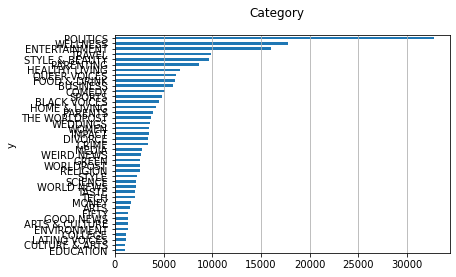

In [7]:
fig, ax = plt.subplots()
fig.suptitle("Category", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [8]:
dtf = dtf[ dtf["y"].isin(['ENTERTAINMENT','POLITICS','TECH','BUSINESS','SPORTS','EDUCATION','CRIME']) ][["y","text"]]

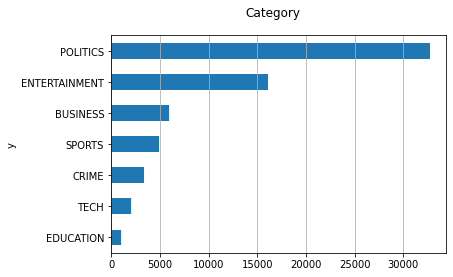

In [9]:
fig, ax = plt.subplots()
fig.suptitle("Category", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [10]:
## split dataset
X_train, X_test, y_train, y_test = model_selection.train_test_split(dtf["text"], dtf["y"], test_size=0.3)## get target

# Random Oversampling

In [11]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler(sampling_strategy="not majority")
X_train, y_train = oversample.fit_resample(np.array(X_train).reshape(-1,1), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [12]:
print(Counter(y_train))

Counter({'SPORTS': 22903, 'ENTERTAINMENT': 22903, 'CRIME': 22903, 'POLITICS': 22903, 'BUSINESS': 22903, 'EDUCATION': 22903, 'TECH': 22903})


In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Feature Matrix Creation

In [14]:
corpus = X_train
maxlen = 50
## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

## generate idx
idx = [tokenizer.encode(seq.split(" "), max_length=50, truncation=True) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)

## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]


In [15]:
corpus = X_test
maxlen = 50
## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

## generate idx
idx = [tokenizer.encode(seq.split(" "), max_length=50, truncation=True) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
    
## feature matrix
X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]



# Model Creation

In [16]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out = nlp(idx, masks, segments)

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out[0])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(7, 
                     activation='softmax')(x)## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    print(layer)
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]            

In [17]:
for layer in model.layers[:4]:
    print(layer)

# Mapping y

In [18]:
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
print(dic_y_mapping)
y_train

{0: 'BUSINESS', 1: 'CRIME', 2: 'EDUCATION', 3: 'ENTERTAINMENT', 4: 'POLITICS', 5: 'SPORTS', 6: 'TECH'}


array([5, 3, 1, ..., 6, 6, 6])

# Training

In [19]:
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=3, shuffle=True, verbose=1, 
                     validation_split=0.3)## test

Epoch 1/3
1754/1754 [==============================] - 1000s 562ms/step - loss: 0.6150 - accuracy: 0.7903 - val_loss: 1.5249 - val_accuracy: 0.5210
Epoch 2/3
1754/1754 [==============================] - 983s 560ms/step - loss: 0.4710 - accuracy: 0.8408 - val_loss: 1.3907 - val_accuracy: 0.5600
Epoch 3/3
1754/1754 [==============================] - 983s 561ms/step - loss: 0.4181 - accuracy: 0.8587 - val_loss: 1.5242 - val_accuracy: 0.5591


In [20]:
predicted_prob = model.predict(X_test)
predicted_prob

array([[9.58716333e-01, 1.91345665e-04, 2.21268328e-05, ...,
        5.71733387e-03, 2.80237116e-04, 3.11033539e-02],
       [5.70118427e-03, 6.26966171e-03, 4.12878165e-07, ...,
        1.61390509e-02, 2.47874241e-02, 2.07426812e-04],
       [1.05855418e-02, 4.45400610e-06, 1.70800843e-06, ...,
        9.80732381e-01, 7.85634766e-05, 8.02854702e-05],
       ...,
       [6.44470099e-03, 7.72432843e-03, 1.51549448e-05, ...,
        1.20486245e-01, 8.30842853e-01, 6.63927523e-04],
       [3.58351128e-04, 9.75615323e-01, 6.02562711e-09, ...,
        6.62806816e-03, 4.70051495e-03, 3.58402867e-05],
       [2.53238738e-01, 1.56920496e-03, 5.90298057e-01, ...,
        3.20860595e-02, 2.19925641e-04, 1.18356623e-01]], dtype=float32)

In [21]:
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

# Evaluation

Accuracy: 0.79
Auc: 0.96
Detail:


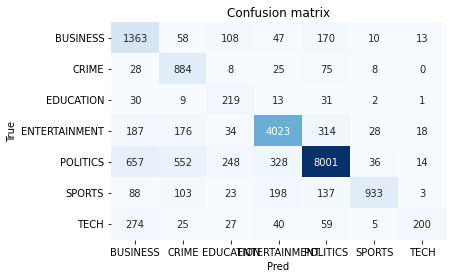

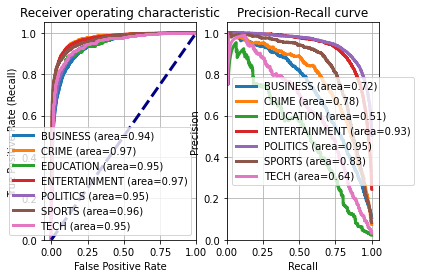

In [22]:
from sklearn import metrics

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
  
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
# print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Save Model

In [23]:
model.save_weights('/content/gdrive/MyDrive/bert-classification.h5')

In [24]:
with open('dicy.json', 'w') as fp:
    json.dump(dic_y_mapping, fp)

In [25]:
with open('invdicy.json', 'w') as fp:
    json.dump(inverse_dic, fp)